In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Time
import time

from typing import List, Tuple, Dict

from config import device

In [3]:
from utils.image_utils import ImageUtils
from utils.wavelet import WaveletProcessor

In [4]:
from network.dataset import WDSSDatasetCompressed

dataset = WDSSDatasetCompressed('D:\\Dev\\MinorProjDataset\\V2\\train', 120, 128, 2)
testing_dataset = WDSSDatasetCompressed('D:\\Dev\\MinorProjDataset\\V2\\train', 120, None, 2)

In [5]:
from network.modules.feature_extractors import LRFrameFeatureExtractor,HRGBufferFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from network.modules.fminr import FourierMappedINR

class WDSSV4(nn.Module):
    def __init__(self):
        super(WDSSV4, self).__init__()

        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 64, [32, 48, 48])
        self.hrg_buffer_feature_extractor = HRGBufferFeatureExtractor(48, 64, [64, 64, 64, 64, 64])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])
        self.inr = FourierMappedINR(32, 32, 12, 64, [64, 64, 64])
        
        # Final Convolution layers
        # Four sets of 3x3 cov layers, to process the different wavelet levels
        self.final_conv = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 3, kernel_size=3, padding=1)
            )
            for _ in range(4)
        ])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffer: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffer, 2)

        lr_frame_feature = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        hr_gbuffer_feature = self.hrg_buffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Split the lr_frame_feature and hr_gbuffer_feature into 2-2 parts
        lr_frame_ff, lr_frame_inr = torch.split(lr_frame_feature, 32, dim=1)
        hr_gbuffer_ff, hr_gbuffer_inr = torch.split(hr_gbuffer_feature, 32, dim=1)

        # Upsample the lr_frame_ff
        lr_frame_ff = ImageUtils.upsample(lr_frame_ff, 2)

        # Feature Fusion, input is concatenated lr_frame_ff and hr_gbuffer_ff
        feature_fusion = self.feature_fusion(torch.cat([lr_frame_ff, hr_gbuffer_ff], dim=1))

        # INR
        inr = self.inr(lr_frame_inr, hr_gbuffer_inr)

        # Element-wise addition
        wavelet_output = feature_fusion + inr

        # Go through the final conv layers
        wavelet_output = torch.cat([self.final_conv[i](wavelet_output[:, i*3:i*3+3, :, :]) for i in range(len(self.final_conv))], dim=1)

        return wavelet_output, WaveletProcessor.batch_iwt(wavelet_output)

In [6]:
# Model
model = WDSSV4().to(device)

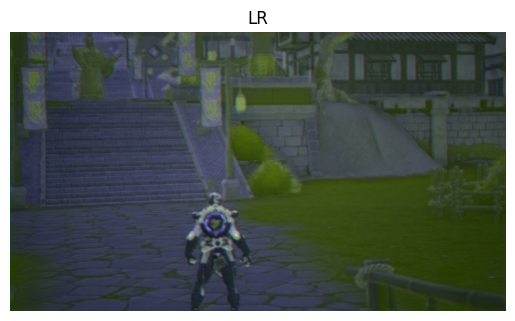

In [22]:
# Test an image
model.eval()
with torch.no_grad():
    lr_frame = testing_dataset[0]['LR'].unsqueeze(0).to(device)
    hr_gbuffer = testing_dataset[0]['GB'].unsqueeze(0).to(device)
    _, image = model(lr_frame, hr_gbuffer)
    ImageUtils.display_image(image[0].cpu(), "LR")

In [32]:
# Variables and train utils

from network.losses import WaveletCriterion, ImageEvaluator
import threading

# Criterion
criterion = WaveletCriterion().to(device)
# Optimizer
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# Data Loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
epoch_loss: float = 0.0

losses_per_epochs: Dict[int, float] = {}

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='

In [18]:
total_epochs = 11

In [33]:
# Training loop

epochs: int = 100

def do_nothing():
    return

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_images = batch['HR'].to(device)
    hr_images_wavelet = WaveletProcessor.batch_wt(hr_images)
    
    optimizer.zero_grad()

    wavelet_out, image_out = model.forward(lr_frames, hr_gbuffers)
    loss, losses = criterion.forward(wavelet_out, hr_images_wavelet, image_out, hr_images)
    # print(loss)
    # print(losses)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i} Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0.0

    for i, batch in enumerate(data_loader):
        if (epoch == 0):
            break

        if (threadu.is_alive()):
            threadu.join()

        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if (threadu.is_alive()):
        threadu.join()
    print(f"Epoch {epoch} Loss: {epoch_loss}")
    # Save the model to model/v4/epoch_{epoch}_time_{time.time()}.pth
    torch.save(model.state_dict(), f"model/v4/epoch_{total_epochs}_time_{time.time()}.pth")
    losses_per_epochs[total_epochs] = epoch_loss

    # Store the losses per epoch to a file
    with open('model/v4.txt', 'w') as f:
        f.write(str(losses_per_epochs))

    total_epochs += 1

    if (epoch % 20) == 0:
        lr = lr / 2.0
        optimizer = optim.Adam(model.parameters(), lr=lr)



Epoch 0 Loss: 0.0
Batch 0 Loss: 0.13845543563365936
Batch 1 Loss: 0.14352481067180634
Batch 2 Loss: 0.1243288666009903
Batch 3 Loss: 0.08894267678260803
Batch 4 Loss: 0.12745100259780884
Batch 5 Loss: 0.11275383830070496
Batch 6 Loss: 0.09650347381830215
Batch 7 Loss: 0.10304700583219528
Batch 8 Loss: 0.09238018840551376
Batch 9 Loss: 0.09886233508586884
Batch 10 Loss: 0.09870857000350952
Batch 11 Loss: 0.08900091052055359
Batch 12 Loss: 0.08886335045099258
Batch 13 Loss: 0.11322305351495743
Batch 14 Loss: 0.08619208633899689
Epoch 1 Loss: 1.6022376045584679
Batch 0 Loss: 0.09682352840900421
Batch 1 Loss: 0.07712799310684204
Batch 2 Loss: 0.09056396782398224
Batch 3 Loss: 0.08046120405197144
Batch 4 Loss: 0.08428816497325897
Batch 5 Loss: 0.09571561962366104
Batch 6 Loss: 0.09886437654495239
Batch 7 Loss: 0.08529195189476013
Batch 8 Loss: 0.09146140515804291
Batch 9 Loss: 0.08686669170856476
Batch 10 Loss: 0.07444373518228531
Batch 11 Loss: 0.09018492698669434
Batch 12 Loss: 0.07840529

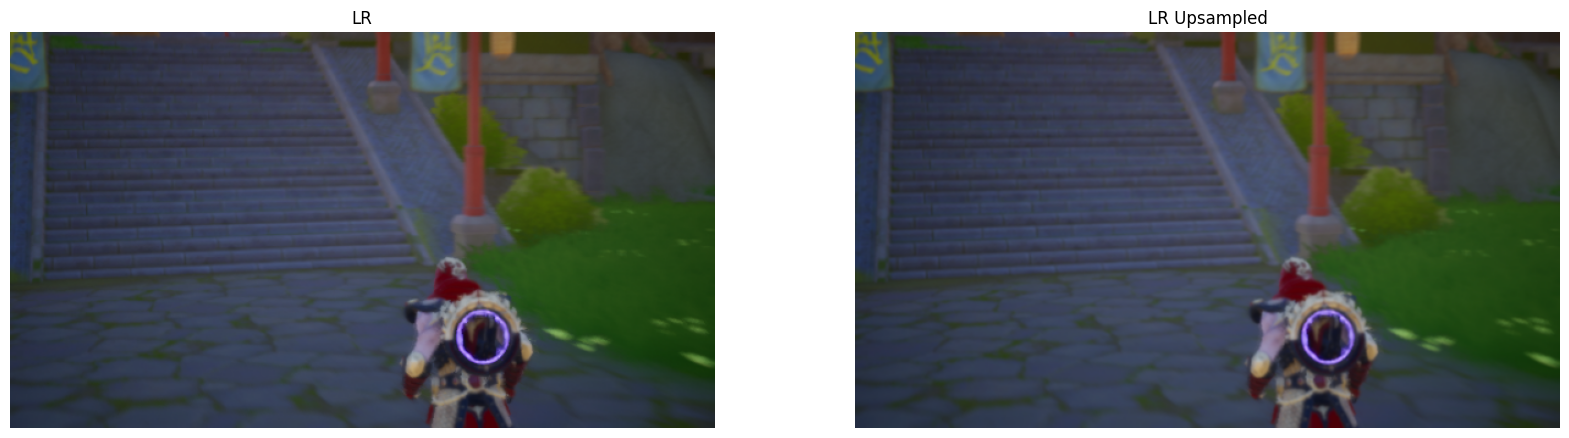

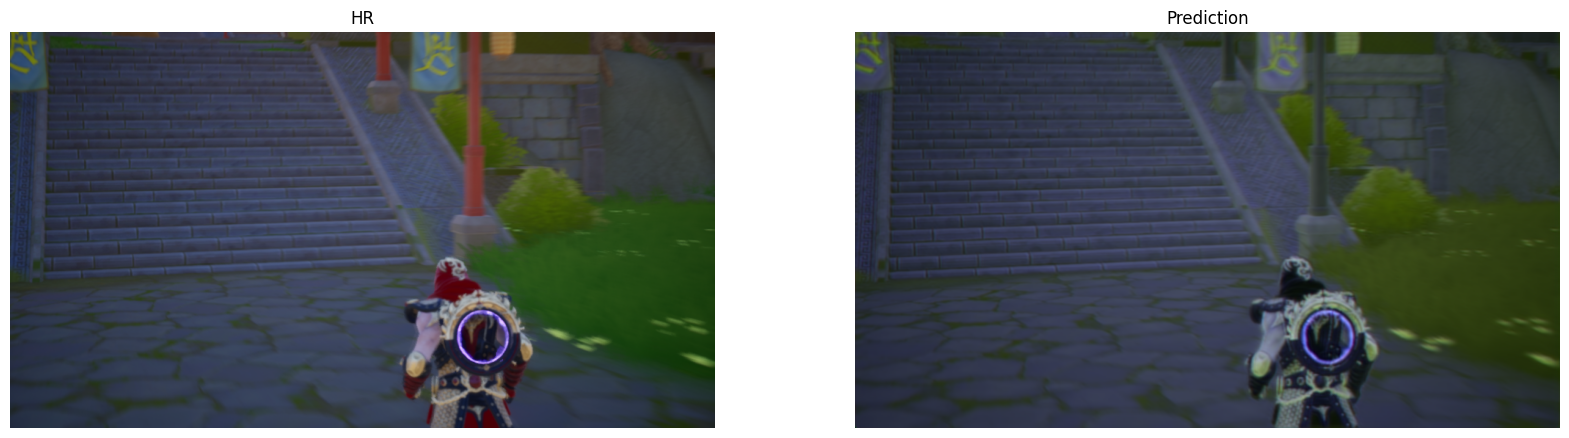

MSE Prediction: 0.0009893941460177302, Upsampled: 0.0003483629261609167
PSNR Prediction: 30.827564239501953, Upsampled: 34.579681396484375
SSIM Prediction: 0.9578031897544861, Upsampled: 0.9463400840759277
LPIPS Prediction: 0.10457362234592438, Upsampled: 0.18910208344459534


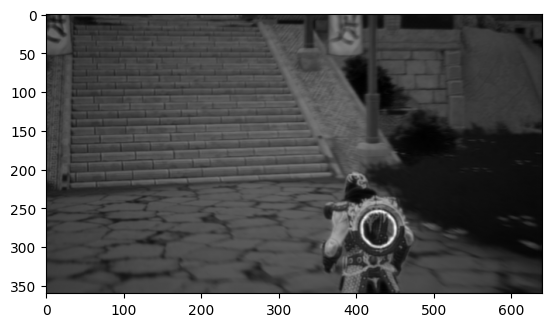

In [48]:
def test_image(data_no: int):
    model.eval()
    with torch.no_grad():
        lr_frame = testing_dataset[data_no]['LR'].unsqueeze(0).to(device)
        hr_gbuffer = testing_dataset[data_no]['GB'].unsqueeze(0).to(device)
        hr_image = testing_dataset[data_no]['HR'].unsqueeze(0).to(device)
        wavelets, image = model(lr_frame, hr_gbuffer)
    
    # Perform bilinear upscaling
    lr_frame_upsampled = ImageUtils.upsample(lr_frame, 2)

    # Display the images
    ImageUtils.display_images([lr_frame.cpu(), lr_frame_upsampled.cpu()], ["LR", "LR Upsampled"])
    ImageUtils.display_images([hr_image.cpu(), image.cpu()], ["HR", "Prediction"])
    
    approx_r = wavelets[0, 2:3, :, :].detach().cpu().numpy()
    # Plot the approx_r
    plt.imshow(approx_r[0], cmap='gray')

    # Compute the losses
    pred_mse = ImageEvaluator.mse(image, hr_image)
    upsampled_mse = ImageEvaluator.mse(lr_frame_upsampled, hr_image)
    print(f"MSE Prediction: {pred_mse}, Upsampled: {upsampled_mse}")

    pred_psnr = ImageEvaluator.psnr(image, hr_image)
    upsampled_psnr = ImageEvaluator.psnr(lr_frame_upsampled, hr_image)
    print(f"PSNR Prediction: {pred_psnr}, Upsampled: {upsampled_psnr}")

    pred_ssim = ImageEvaluator.ssim(image, hr_image)
    upsampled_ssim = ImageEvaluator.ssim(lr_frame_upsampled, hr_image)
    print(f"SSIM Prediction: {pred_ssim}, Upsampled: {upsampled_ssim}")

    pred_lpips = ImageEvaluator.lpips(image, hr_image).item()
    upsampled_lpips = ImageEvaluator.lpips(lr_frame_upsampled, hr_image).item()
    print(f"LPIPS Prediction: {pred_lpips}, Upsampled: {upsampled_lpips}")

test_image(60)

    